# COCO dataset

In [5]:
import torch
from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor
import os

import fiftyone

dataset_train = fiftyone.zoo.load_zoo_dataset(
    "coco-2017",
    split="train",
    label_types=["detections", "segmentations"],
    classes=["person", "bicycle", "car"],
    max_samples=200,
)

# Visualize the dataset in the FiftyOne App
# session = fiftyone.launch_app(dataset)

# Create a data loader
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=4, shuffle=True)

Found annotations at 'C:\Users\leona\fiftyone\coco-2017\raw\instances_train2017.json'


Sufficient images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'coco-2017-train-200'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [8]:
# Path where FiftyOne stores the dataset
dataset_dir = r"C:\Users\leona\fiftyone\coco-2017\train\data"
ann_file = r"C:\Users\leona\fiftyone\coco-2017\train\labels.json"

dataset = CocoDetection(root=dataset_dir, annFile=ann_file, transform=ToTensor())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


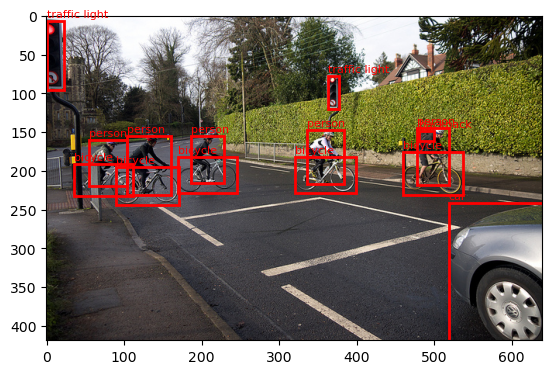

In [9]:
# Visualize one sample
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms.functional import to_pil_image

img, targets = dataset[0]
img = to_pil_image(img)

fig, ax = plt.subplots()
ax.imshow(img)

for obj in targets:
    bbox = obj['bbox']  # [x, y, width, height]
    label = dataset.coco.loadCats(obj['category_id'])[0]['name']
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                             linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.text(bbox[0], bbox[1] - 5, label, color='red', fontsize=8)

plt.show()

Pros:
 - Images from the street
 - bicycle, person and car classes available
 - High quality images

Cons:
 - Preprocessing for classification needed (dataset is build for segmentation)
 - There might be problems how to preprocess bicycles (because there is a cycle and a person) vs. pedestrians

## Croping for classification

In [19]:
from PIL import Image

target_classes = ["person", "bicycle", "car"]

# Get category IDs
cat_ids = dataset.coco.getCatIds(catNms=target_classes)

# Get image IDs containing these categories
img_ids = dataset.coco.getImgIds(catIds=cat_ids)

dataDir = dataset_dir
output_dir =  r"C:\Users\leona\fiftyone\coco-2017\cropped"

# dataset_dir = r"C:\Users\leona\fiftyone\coco-2017\train\data"
# ann_file = r"C:\Users\leona\fiftyone\coco-2017\train\labels.json"

for img_id in img_ids:
    img_info = dataset.coco.loadImgs(img_id)[0]
    img_path = os.path.join(dataDir, img_info['file_name'])
    
    # Open the image
    img = Image.open(img_path).convert("RGB")
    
    # Get annotations for this image
    ann_ids = dataset.coco.getAnnIds(imgIds=img_id, catIds=cat_ids, iscrowd=None)
    anns = dataset.coco.loadAnns(ann_ids)
    
    for i, ann in enumerate(anns):
        bbox = ann['bbox']  # COCO format: [x, y, width, height]
        x, y, w, h = map(int, bbox)
        
        # Crop and save
        cropped_img = img.crop((x, y, x + w, y + h))
        class_name = dataset.coco.loadCats(ann['category_id'])[0]['name']
        save_path = os.path.join(output_dir, f"{img_id}_{i}_{class_name}.jpg")
        cropped_img.save(save_path)

In [29]:
output_dir = r"C:\Users\leona\fiftyone\coco-2017\cropped"
min_width = 50
min_height = 50

for filename in os.listdir(output_dir):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        path = os.path.join(output_dir, filename)
        try:
            with Image.open(path) as img:  # ensures the file is closed automatically
                width, height = img.size
            if width < min_width or height < min_height:
                print(f"Deleting small image: {filename} ({width}x{height})")
                os.remove(path)
        except Exception as e:
            print(f"Error opening {filename}: {e}")


I deleted all people riding a bike and classified as person and all not interpretable images manually.

In [30]:
c_car = 0
c_bike = 0
c_person = 0

for filename in os.listdir(output_dir):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        fname = filename.lower()
        if 'car' in fname:
            c_car += 1
        elif 'person' in fname:
            c_person += 1
        elif 'bicycle' in fname:
            c_bike += 1

print(f"Cars: {c_car}, Bicycles: {c_bike}, Persons: {c_person}")


Cars: 176, Bicycles: 172, Persons: 139


In [31]:
from PIL import ImageOps

input_dir = r"C:\Users\leona\fiftyone\coco-2017\cropped"
output_dir = r"C:\Users\leona\fiftyone\coco-2017\cropped_resized"

os.makedirs(output_dir, exist_ok=True)

# Target size for all images
target_size = (128, 128)

# Classes to look for in filenames
target_classes = ["person", "bicycle", "car"]

for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        if any(cls in filename.lower() for cls in target_classes):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)

            try:
                with Image.open(input_path) as img:
                    # Resize with padding to maintain aspect ratio
                    resized_img = ImageOps.pad(img, target_size, color=(0,0,0))
                    resized_img.save(output_path)
                    print(f"Resized {filename} -> {target_size}")
            except Exception as e:
                print(f"Error processing {filename}: {e}")


Resized 101636_0_bicycle.jpg -> (128, 128)
Resized 101636_13_bicycle.jpg -> (128, 128)
Resized 101636_18_bicycle.jpg -> (128, 128)
Resized 101636_1_bicycle.jpg -> (128, 128)
Resized 101636_2_bicycle.jpg -> (128, 128)
Resized 101636_3_car.jpg -> (128, 128)
Resized 101636_8_person.jpg -> (128, 128)
Resized 102306_0_bicycle.jpg -> (128, 128)
Resized 102306_13_car.jpg -> (128, 128)
Resized 102306_14_car.jpg -> (128, 128)
Resized 102306_15_car.jpg -> (128, 128)
Resized 102306_1_bicycle.jpg -> (128, 128)
Resized 102306_28_car.jpg -> (128, 128)
Resized 102405_0_car.jpg -> (128, 128)
Resized 102405_3_person.jpg -> (128, 128)
Resized 102741_2_car.jpg -> (128, 128)
Resized 102741_3_car.jpg -> (128, 128)
Resized 102741_5_car.jpg -> (128, 128)
Resized 102741_8_car.jpg -> (128, 128)
Resized 103817_0_bicycle.jpg -> (128, 128)
Resized 103817_1_car.jpg -> (128, 128)
Resized 103817_2_car.jpg -> (128, 128)
Resized 10393_0_bicycle.jpg -> (128, 128)
Resized 105349_1_car.jpg -> (128, 128)
Resized 105349_2_

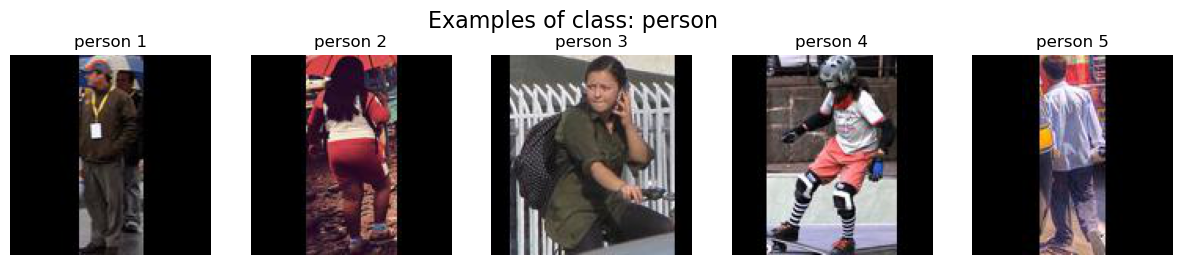

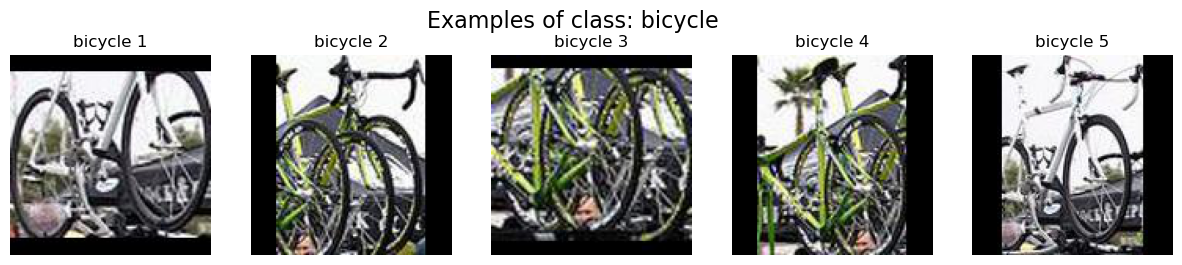

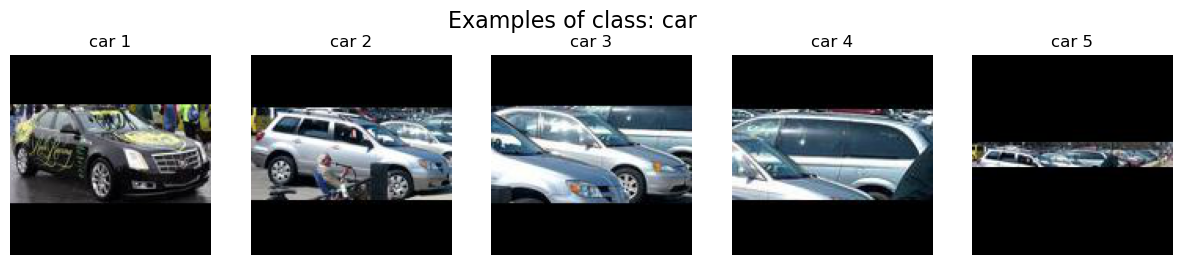

In [32]:
import matplotlib.pyplot as plt

input_dir = r"C:\Users\leona\fiftyone\coco-2017\cropped_resized"
target_classes = ["person", "bicycle", "car"]
max_examples = 5  # max images per class

# Prepare a dictionary to store images per class
images_per_class = {cls: [] for cls in target_classes}

# Collect images
for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        fname_lower = filename.lower()
        for cls in target_classes:
            if cls in fname_lower and len(images_per_class[cls]) < max_examples:
                path = os.path.join(input_dir, filename)
                try:
                    img = Image.open(path)
                    images_per_class[cls].append(img)
                except Exception as e:
                    print(f"Error opening {filename}: {e}")
                break  # Stop checking other classes for this file

# Plot images using matplotlib
for cls, imgs in images_per_class.items():
    if len(imgs) == 0:
        continue

    plt.figure(figsize=(15, 3))
    plt.suptitle(f"Examples of class: {cls}", fontsize=16)
    for i, img in enumerate(imgs):
        plt.subplot(1, max_examples, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{cls} {i+1}")
    plt.show()